<a href="https://colab.research.google.com/github/RanjKsan/Cyberbullying-detection-using-Transformer-model-and-XAI/blob/main/ROBERTA%20and%20T5%20with%20LIME%20and%20SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**T5**

In [ ]:
pip install transformers torch wandb scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from tabulate import tabulate  # For printing metrics in a nice table format

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
data = pd.read_csv("/content/cyberbullying_tweets.csv")

In [ ]:
# Preprocess the dataset
data["tweet_text"] = data["tweet_text"].astype(str)
data["cyberbullying_type"] = data["cyberbullying_type"].astype(str)

In [ ]:
# Split the dataset
X_train, X_temp, y_train, y_temp = train_test_split(
    data["tweet_text"], data["cyberbullying_type"], test_size=0.3, random_state=42, stratify=data["cyberbullying_type"]
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [ ]:
# Define a custom dataset
class CyberbullyingDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts.iloc[index]
        label = self.labels.iloc[index]

        # T5 expects input as "classify: {text}" for classification tasks
        input_text = f"classify: {text}"

        # Tokenize
        encoding = self.tokenizer(
            input_text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        label_encoding = self.tokenizer(
            label,
            max_length=10,  # Keep labels short
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": label_encoding["input_ids"].squeeze(0),
        }

In [ ]:
# Load tokenizer and model
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)
model = model.to(device)

# Hyperparameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 1
LEARNING_RATE = 3e-5

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
# Create DataLoaders
train_dataset = CyberbullyingDataset(X_train, y_train, tokenizer, MAX_LEN)
val_dataset = CyberbullyingDataset(X_val, y_val, tokenizer, MAX_LEN)
test_dataset = CyberbullyingDataset(X_test, y_test, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Function to calculate metrics
def calculate_metrics(preds, labels):
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return accuracy, precision, recall, f1

In [ ]:
import gc

def clear_memory():
    torch.cuda.empty_cache()  # Empty the GPU cache
    gc.collect()  # Collect garbage


In [ ]:

# Training function
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0

    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    return total_loss / len(data_loader)

# Evaluation function
def eval_model(model, data_loader, device):
    model.eval()
    total_loss = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_loss += loss.item()

            # Decode predictions and labels
            preds = tokenizer.batch_decode(
                torch.argmax(outputs.logits, dim=-1),
                skip_special_tokens=True
            )
            labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

            all_preds.extend(preds)
            all_labels.extend(labels)

    accuracy, precision, recall, f1 = calculate_metrics(all_preds, all_labels)
    return total_loss / len(data_loader), accuracy, precision, recall, f1, all_preds, all_labels

# Training loop
metrics_table = [["Epoch", "Training Loss", "Validation Loss", "Accuracy", "Precision", "Recall", "F1-Score"]]
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")

    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_accuracy, val_precision, val_recall, val_f1, _, _ = eval_model(model, val_loader, device)

    metrics_table.append([epoch + 1, train_loss, val_loss, val_accuracy, val_precision, val_recall, val_f1])
    print(f"Epoch {epoch + 1} completed.")

# Print metrics in table format
print(tabulate(metrics_table, headers="firstrow", tablefmt="fancy_grid"))

# Test the model
test_loss, test_accuracy, test_precision, test_recall, test_f1, test_preds, test_labels = eval_model(model, test_loader, device)
print("\nTest Metrics:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

print("\nClassification Report:")
print(classification_report(test_labels, test_preds))

Epoch 1/1


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1 completed.
╒═════════╤═════════════════╤═══════════════════╤════════════╤═════════════╤══════════╤════════════╕
│   Epoch │   Training Loss │   Validation Loss │   Accuracy │   Precision │   Recall │   F1-Score │
╞═════════╪═════════════════╪═══════════════════╪════════════╪═════════════╪══════════╪════════════╡
│       1 │        0.604779 │         0.0653325 │   0.747694 │    0.854919 │ 0.747694 │   0.783837 │
╘═════════╧═════════════════╧═══════════════════╧════════════╧═════════════╧══════════╧════════════╛

Test Metrics:
Test Loss: 0.0640
Test Accuracy: 0.7434
Test Precision: 0.8461
Test Recall: 0.7434
Test F1-Score: 0.7793

Classification Report:
                        precision    recall  f1-score   support

                   age       1.00      0.95      0.97      1199
     age_cyberbullying       0.00      0.00      0.00         0
                ageity       0.00      0.00      0.00         0
                ethnic       0.00      0.00      0.00         0
  ethnic_cy

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

In [ ]:
clear_memory()

In [ ]:
# Save the model
model.save_pretrained("t5-cyberbullying-model")
tokenizer.save_pretrained("t5-cyberbullying-model")

('t5-cyberbullying-model/tokenizer_config.json',
 't5-cyberbullying-model/special_tokens_map.json',
 't5-cyberbullying-model/spiece.model',
 't5-cyberbullying-model/added_tokens.json')

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=a518a802213b47a7f8eebd1bfbdaabcbe7bf8da8d8485ea4a15ba2c19a279cc1
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


**LIME + T5**


🔷 **LIME Explanation for T5 Cyberbullying Model** 🔷
📝 Sample Text: DRUG SHIT NIGGERS THINKS BADASS TAKEOVER WORLD DEVICE MIKE SANDERS JT GIBSON FUCK DUMB AND DUMBER ARSONS PAT DUKE JONES



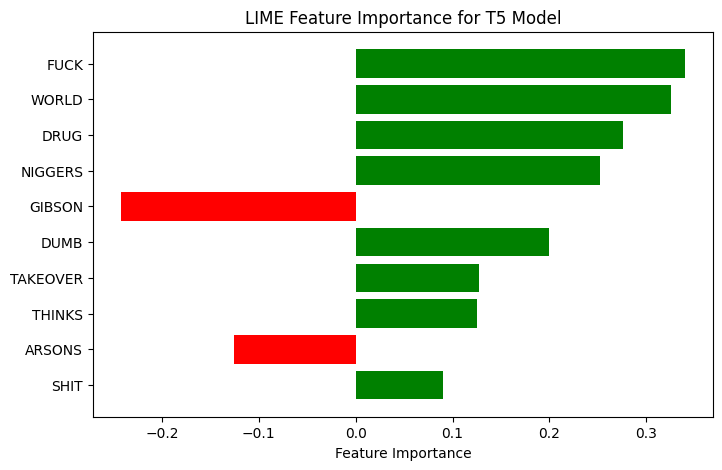

age: 0.0000
ethnicity: 1.0000
gender: 0.0000
not_cyberbullying: 0.0000
other_cyberbullying: 0.0000
religion: 0.0000

🔹 Local Explanation:
  FUCK: 🟢 Positive (0.3396)
  WORLD: 🟢 Positive (0.3255)
  DRUG: 🟢 Positive (0.2759)
  NIGGERS: 🟢 Positive (0.2523)
  GIBSON: 🔴 Negative (-0.2422)
  DUMB: 🟢 Positive (0.1999)
  TAKEOVER: 🟢 Positive (0.1269)
  THINKS: 🟢 Positive (0.1253)
  ARSONS: 🔴 Negative (-0.1251)
  SHIT: 🟢 Positive (0.0901)


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from lime.lime_text import LimeTextExplainer
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, HTML

# Ensure correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained T5 model and tokenizer
model_name = "t5-cyberbullying-model"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)
model.eval()

# Encode labels for numerical mapping
label_encoder = LabelEncoder()
label_encoder.fit(y_train)  # Fit encoder using training labels

# ==============================
#  🔹 LIME Implementation for T5 🔹
# ==============================

def predict_proba_t5(texts):
    """Returns class probabilities for given input texts using the T5 model."""
    inputs = [f"classify: {text}" for text in texts]
    encoding = tokenizer(inputs, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.generate(**encoding)

    preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    pred_probs = np.zeros((len(preds), len(label_encoder.classes_)))

    for i, pred in enumerate(preds):
        if pred in label_encoder.classes_:
            pred_probs[i, label_encoder.transform([pred])[0]] = 1  # Assign probability 1 to predicted class
    return pred_probs


# Function to apply LIME
def explain_with_lime_t5(text_sample):
    """
    Apply LIME explanation to a given text for the T5 model.

    Args:
        text_sample: The text sample to explain

    Returns:
        None (Displays visualizations)
    """
    class_names = label_encoder.classes_
    explainer = LimeTextExplainer(class_names=class_names)

    # Generate LIME explanation
    explanation_T5 = explainer.explain_instance(
        text_sample,
        predict_proba_t5,
        num_features=10,
        num_samples=100
    )

    # 1️⃣ **Bar Plot: Feature Importance**
    weights = dict(explanation_T5.as_list())
    words = list(weights.keys())
    values = list(weights.values())

    plt.figure(figsize=(8, 5))
    plt.barh(words, values, color=['green' if v > 0 else 'red' for v in values])
    plt.xlabel("Feature Importance")
    plt.title("LIME Feature Importance for T5 Model")
    plt.gca().invert_yaxis()
    plt.show()

    # 2️⃣ **Probability Scores for Each Class**
    probabilities = predict_proba_t5([text_sample])[0]
    for i, label in enumerate(class_names):
        print(f"{label}: {probabilities[i]:.4f}")

    # 3️⃣ **Local Explanation (Positive & Negative Contributions)**
    print("\n🔹 Local Explanation:")
    for word, weight in weights.items():
        print(f"  {word}: {'🟢 Positive' if weight > 0 else '🔴 Negative'} ({weight:.4f})")

    # Display highlighted HTML text
    display(HTML(explanation_T5.as_html()))

    # 4️⃣ **Highlighted Text (HTML)**
    return explanation_T5


# ==============================
#  🔹 Apply LIME to Sample Text 🔹
# ==============================

# Select a sample text from validation set
sample_text = X_val.iloc[0]

print("\n🔷 **LIME Explanation for T5 Cyberbullying Model** 🔷")
print(f"📝 Sample Text: {sample_text}\n")
explanation_T5=explain_with_lime_t5(sample_text)

# Clear GPU memory after execution
clear_memory()


**LIME METRICS**

In [ ]:
target_label = explanation_T5.available_labels()[0]

# 1️⃣ Intercept & Feature Contributions
print(f"Intercept for label {target_label}: {explanation_T5.intercept[target_label]:.4f}\n")
print(f"Feature Contributions for label {target_label}:")
# explanation.local_exp is a dict mapping label index to list of (feature_index, weight) tuples.
# For text explanations, the "feature_index" is actually the word (as a string) when using LimeTextExplainer.
for word, weight in explanation_T5.local_exp[target_label]:
    print(f"  {word}: {weight:.4f}")

# 2️⃣ Local Prediction
# The local prediction is the sum of the intercept and the contributions.
local_prediction = explanation_T5.intercept[target_label] + sum(weight for _, weight in explanation_T5.local_exp[target_label])
print(f"\nLocal Prediction (Intercept + Sum of Feature Contributions): {local_prediction:.4f}")

# 3️⃣ Local Fidelity (R²)
# If your LIME Explanation object computed a fidelity score, it is usually stored in 'explanation.score'
if hasattr(explanation_T5, "score") and explanation_T5.score is not None:
    print(f"\nLocal Fidelity (R²): {explanation_T5.score:.4f}")
else:
    print("\nLocal Fidelity (R²) is not directly available in this explanation object.")
clear_memory()

Intercept for label 1: -0.2762

Feature Contributions for label 1:
  12: 0.3396
  6: 0.3255
  0: 0.2759
  2: 0.2523
  11: -0.2422
  13: 0.1999
  5: 0.1269
  3: 0.1253
  16: -0.1251
  1: 0.0901

Local Prediction (Intercept + Sum of Feature Contributions): 1.0921

Local Fidelity (R²): 0.7381


**SHAP + T5**

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 1/10 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 3/10 [00:21<00:27,  3.96s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 4/10 [00:34<00:45,  7.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 5/10 [00:54<01:01, 12.22s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 6/10 [01:09<00:52, 13.21s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 7/10 [01:18<00:35, 11.87s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 8/10 [01:27<00:22, 11.05s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 9/10 [01:35<00:10, 10.11s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 10/10 [01:44<00:00,  9.77s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 11it [01:54, 11.45s/it]


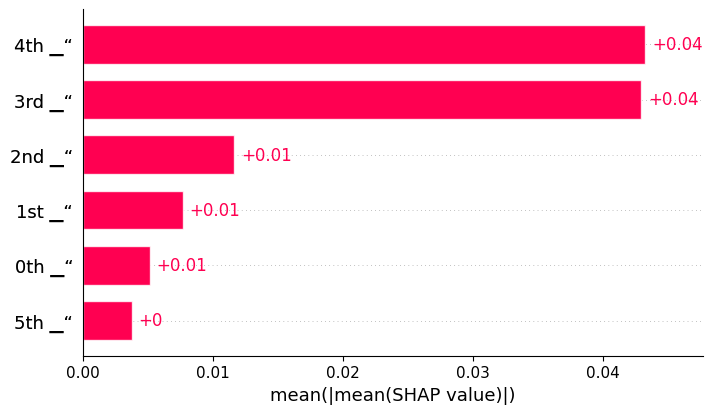

In [ ]:
import shap
import torch
import numpy as np
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sklearn.preprocessing import LabelEncoder

# Ensure correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained T5 model and tokenizer
model_name = "t5-cyberbullying-model"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)
model.eval()

# Encode labels for numerical mapping
label_encoder = LabelEncoder()
label_encoder.fit(y_train)  # Fit encoder using training labels


# ==============================
#  🔹 SHAP Implementation for T5 🔹
# ==============================

def predictor_t5(texts):
    """Predict function for SHAP, processes input texts and returns logits."""
    inputs = [f"classify: {text}" for text in texts]
    encoding = tokenizer(inputs, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.generate(**encoding)

    preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    pred_probs = np.zeros((len(preds), len(label_encoder.classes_)))

    for i, pred in enumerate(preds):
        if pred in label_encoder.classes_:
            pred_probs[i, label_encoder.transform([pred])[0]] = 1  # Assign probability 1 to predicted class
    return pred_probs


# Initialize SHAP explainer
explainer = shap.Explainer(
    predictor_t5,
    masker=shap.maskers.Text(tokenizer),
    output_names=label_encoder.classes_.tolist()
)

# ==============================
#  🔹 Apply SHAP to Sample Texts 🔹
# ==============================

# Select a sample of texts to explain
sample_texts = X_val.sample(n=10, random_state=42).tolist()  # Reduce to 10 samples for efficiency

# Compute SHAP values
shap_values = explainer(sample_texts)

# 1️⃣ **Visualization: Force plot for first sample**
shap.plots.text(shap_values[0])  # Show explanation for first sample

# 2️⃣ **Visualization: Bar plot of mean absolute SHAP values**
shap.plots.bar(shap_values.mean(0))

# Clear GPU memory after execution
torch.cuda.empty_cache()


**SHAP METRICS**

In [ ]:
import numpy as np
import shap
import torch

def compute_shap_fidelity_t5(explainer, model, tokenizer, texts, top_k=5):
    """
    Computes fidelity score for SHAP explanations on a T5 model.

    Parameters:
        explainer (shap.Explainer): SHAP explainer object.
        model (torch.nn.Module): Trained T5 model.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for T5.
        texts (list): List of texts (from dataset) to compute fidelity scores.
        top_k (int): Number of top important tokens to mask.

    Returns:
        float: Average fidelity score over all samples.
    """
    fidelity_scores = []

    for text in texts:
        # Tokenize input
        input_text = f"classify: {text}"
        inputs = tokenizer(input_text, return_tensors="pt").to(device)

        # Get original prediction
        with torch.no_grad():
            outputs = model.generate(**inputs)
        orig_pred = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

        # Compute SHAP values
        shap_values = explainer([text])

        # Extract absolute SHAP values per token
        token_shap_values = np.abs(shap_values.values[0])  # Shape: (seq_len, num_classes)
        token_importance = token_shap_values.sum(axis=1)  # Sum across classes for each token

        # Get top-k important tokens
        top_k_indices = np.argsort(token_importance)[-top_k:]

        # Mask top-k tokens by replacing them with [MASK]
        tokenized_text = tokenizer.tokenize(input_text)
        for idx in top_k_indices:
            # Ensure tokenized_text[idx] remains a string after masking
            tokenized_text[idx] = str(tokenizer.mask_token) # Modified line

        masked_input_text = tokenizer.convert_tokens_to_string(tokenized_text)
        masked_inputs = tokenizer(masked_input_text, return_tensors="pt").to(device)

        # Get prediction on masked input
        with torch.no_grad():
            masked_outputs = model.generate(**masked_inputs)
        masked_pred = tokenizer.batch_decode(masked_outputs, skip_special_tokens=True)[0]

        # Compute fidelity score (binary: 1 if same, 0 if different)
        fidelity_score = 1 if orig_pred == masked_pred else 0
        fidelity_scores.append(fidelity_score)

    # Compute average fidelity score across all samples
    avg_fidelity_score = np.mean(fidelity_scores)

    return round(avg_fidelity_score, 4)


# Select a subset of validation data to compute fidelity scores (reduce size for efficiency)
sample_texts = X_val.sample(n=10, random_state=42).tolist()

# Compute Fidelity Score for T5
fidelity_score_t5 = compute_shap_fidelity_t5(explainer, model, tokenizer, sample_texts)
print("Average SHAP Fidelity Score for T5:", fidelity_score_t5)
clear_memory()

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:11, 11.83s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:10, 10.27s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Average SHAP Fidelity Score for T5: 0.9


**ROBERTA**

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:

# Load dataset
df = pd.read_csv("/content/cyberbullying_tweets.csv")


In [ ]:
# Encode labels
label_encoder = LabelEncoder()
df["cyberbullying_type"] = label_encoder.fit_transform(df["cyberbullying_type"])

# Split dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["tweet_text"].tolist(), df["cyberbullying_type"].tolist(), test_size=0.2, random_state=42
)

# Load tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
# Custom Dataset class
class CyberbullyingDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }


In [ ]:
# Create dataset objects
train_dataset = CyberbullyingDataset(train_texts, train_labels, tokenizer)
val_dataset = CyberbullyingDataset(val_texts, val_labels, tokenizer)

# Load model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(label_encoder.classes_))
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
import gc

def clear_memory():
    torch.cuda.empty_cache()  # Empty the GPU cache
    gc.collect()  # Collect garbage

In [ ]:
# Define compute metrics
def compute_metrics(p):
    pred, labels = p
    preds = pred.argmax(axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
        "f1": f1_score(labels, preds, average="weighted"),
    }

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results_roberta",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs_roberta",
    logging_steps=10,
    save_steps=100,
    load_best_model_at_end=True,
    report_to="none"  # Disable wandb integration
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()
clear_memory()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


**LIME + ROBERTA**

In [ ]:
!pip install lime

In [ ]:
from lime.lime_text import LimeTextExplainer
from transformers import RobertaTokenizer
import torch.nn.functional as F

# Initialize tokenizer (must match your training tokenizer)
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Define prediction function
def predictor(texts):
    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=512,  # Match your training setting
        return_tensors="pt"
    ).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    return F.softmax(outputs.logits, dim=1).cpu().numpy()

# Initialize explainer with your class names
explainer = LimeTextExplainer(class_names=label_encoder.classes_)
clear_memory()


🔷 **LIME Explanation for RoBERTa** 🔷


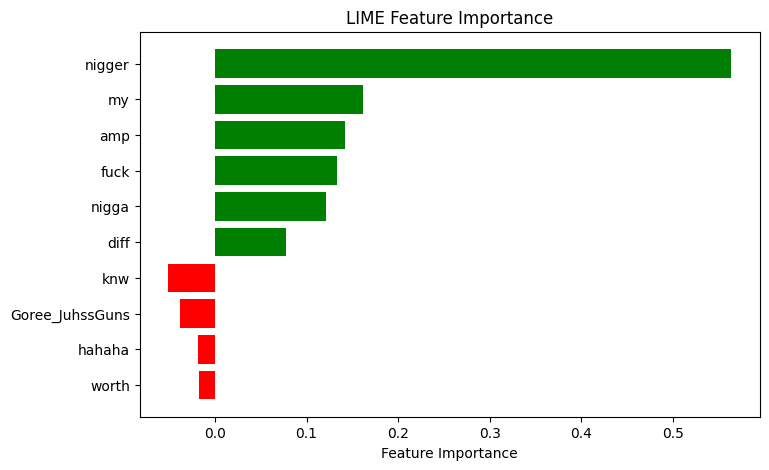

age: 0.0002
ethnicity: 0.9991
gender: 0.0003
not_cyberbullying: 0.0001
other_cyberbullying: 0.0002
religion: 0.0001

🔹 Local Explanation:
  nigger: 🟢 Positive (0.5641)
  my: 🟢 Positive (0.1614)
  amp: 🟢 Positive (0.1422)
  fuck: 🟢 Positive (0.1336)
  nigga: 🟢 Positive (0.1217)
  diff: 🟢 Positive (0.0771)
  knw: 🔴 Negative (-0.0517)
  Goree_JuhssGuns: 🔴 Negative (-0.0382)
  hahaha: 🔴 Negative (-0.0187)
  worth: 🔴 Negative (-0.0177)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lime.lime_text import LimeTextExplainer
from IPython.display import display, HTML
import torch # Import torch to access torch.device

# Function to apply LIME for any transformer model (BERT, RoBERTa, DistilBERT)
def explain_with_lime_roberta(model, tokenizer, text_sample):
    """
    Apply LIME explanation on a given text for a given transformer model.

    Args:
        model: Transformer model (BERT, RoBERTa, DistilBERT)
        tokenizer: Tokenizer for the model
        text_sample: The text sample to explain

    Returns:
        None (Displays visualizations)
    """

    # Get the device (cuda if available, else cpu)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    class_names = label_encoder.classes_
    explainer = LimeTextExplainer(class_names=class_names)

    # Define prediction function for LIME
    def predict_fn(texts):
        inputs = tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        ).to(device) # Now 'device' is accessible

        with torch.no_grad():
            outputs = model(**inputs)

        return torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()

    # Generate LIME explanation
    explanation_roberta = explainer.explain_instance(
        text_sample,
        predict_fn,
        num_features=10,
        num_samples=100
    )

    # 1️⃣ **Bar Plot: Feature Importance**
    weights = dict(explanation_roberta.as_list())
    words = list(weights.keys())
    values = list(weights.values())

    plt.figure(figsize=(8, 5))
    plt.barh(words, values, color=['green' if v > 0 else 'red' for v in values])
    plt.xlabel("Feature Importance")
    plt.title("LIME Feature Importance")
    plt.gca().invert_yaxis()
    plt.show()

    # 2️⃣ **Probability Scores for Each Class**
    probabilities = predict_fn([text_sample])[0]
    for i, label in enumerate(class_names):
        print(f"{label}: {probabilities[i]:.4f}")

    # 3️⃣ **Local Explanation (Positive & Negative Contributions)**
    print("\n🔹 Local Explanation:")
    for word, weight in weights.items():
        print(f"  {word}: {'🟢 Positive' if weight > 0 else '🔴 Negative'} ({weight:.4f})")

    # Display highlighted HTML text
    display(HTML(explanation_roberta.as_html()))

    # 4️⃣ **Highlighted Text (HTML)**
    return explanation_roberta

# Sample text from validation set
sample_text = val_texts[0]


print("\n🔷 **LIME Explanation for RoBERTa** 🔷")
explanation_roberta=explain_with_lime_roberta(model, tokenizer, sample_text)
clear_memory()

In [ ]:
# Retrieve top predicted label
target_label = explanation_roberta.available_labels()[0]

# 1️⃣ Intercept & Feature Contributions
print(f"Intercept for label {target_label}: {explanation_roberta.intercept[target_label]:.4f}\n")
print(f"Feature Contributions for label {target_label}:")
for word, weight in explanation_roberta.local_exp[target_label]:
    print(f"  {word}: {weight:.4f}")

# 2️⃣ Local Prediction
local_prediction = explanation_roberta.intercept[target_label] + sum(weight for _, weight in explanation_roberta.local_exp[target_label])
print(f"\nLocal Prediction (Intercept + Sum of Feature Contributions): {local_prediction:.4f}")

# 3️⃣ Local Fidelity (R²)
if hasattr(explanation_roberta, "score") and explanation_roberta.score is not None:
    print(f"\nLocal Fidelity (R²): {explanation_roberta.score:.4f}")
else:
    print("\nLocal Fidelity (R²) is not directly available in this explanation object.")

clear_memory()

Intercept for label 1: 0.0386

Feature Contributions for label 1:
  18: 0.5641
  7: 0.1614
  17: 0.1422
  10: 0.1336
  16: 0.1217
  14: 0.0771
  12: -0.0517
  0: -0.0382
  1: -0.0187
  6: -0.0177

Local Prediction (Intercept + Sum of Feature Contributions): 1.1123

Local Fidelity (R²): 0.7931


**SHAP + ROBERTA**

PartitionExplainer explainer: 51it [01:35,  2.12s/it]


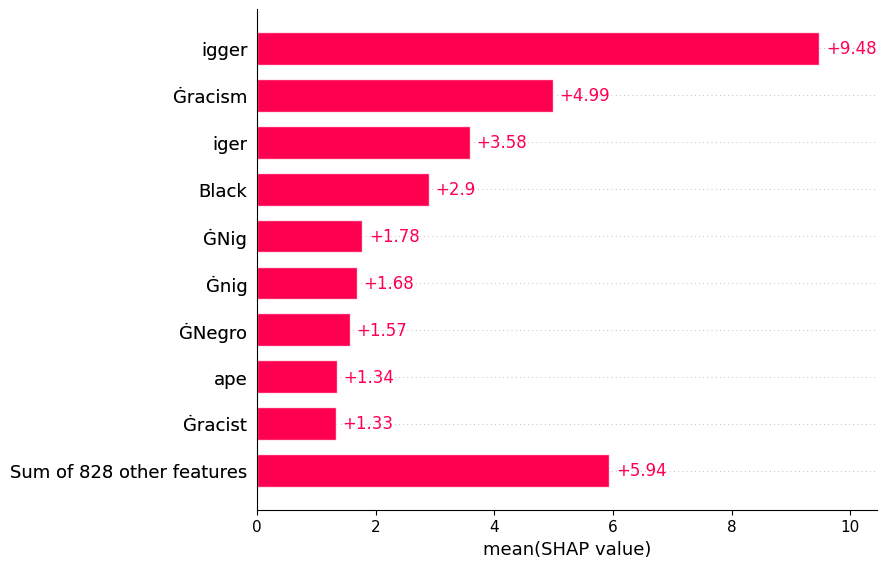

In [ ]:
import shap
import torch
import numpy as np
import random

# Ensure 'device' is defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a prediction function compatible with SHAP
def predictor_roberta(texts):
    if isinstance(texts, str):
        texts = [texts]

    # Tokenize and process input
    encodings = tokenizer(
        [str(text) for text in texts],
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

    # Move tensors to the same device as the model
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    return outputs.logits.cpu().numpy()

# Initialize SHAP explainer
explainer_shap = shap.Explainer(
    predictor_roberta,
    masker=shap.maskers.Text(tokenizer),
    output_names=label_encoder.classes_.tolist()
)

# Select a sample of texts to explain
sample_texts = random.sample(val_texts, 50)

# Compute SHAP values
shap_values = explainer_shap(sample_texts)

# Visualization 1: Force plot for individual predictions
shap.plots.text(shap_values[0])

# Visualization 2: Bar plot of mean absolute SHAP values
shap.plots.bar(shap_values.mean(0)[:, 1])

torch.cuda.empty_cache()

**SHAP METRICS**

In [ ]:
import numpy as np
import shap
import torch

def compute_shap_fidelity_roberta(explainer, model, tokenizer, texts, top_k=5):
    """
    Computes fidelity score for SHAP explanations on a RoBERTa model.

    Parameters:
        explainer (shap.Explainer): SHAP explainer object.
        model (torch.nn.Module): Trained RoBERTa model.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for RoBERTa.
        texts (list): List of texts (from dataset) to compute fidelity scores.
        top_k (int): Number of top important tokens to mask.

    Returns:
        float: Average fidelity score over all samples.
    """
    fidelity_scores = []

    for text in texts:
        # Tokenize input
        inputs = tokenizer(text, return_tensors="pt")
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)

        # Get original prediction probability
        with torch.no_grad():
            logits = model(input_ids, attention_mask=attention_mask).logits
            orig_pred_prob = torch.softmax(logits, dim=-1).max().item()  # Max probability class

        # Compute SHAP values
        shap_values = explainer([text])

        # Extract absolute SHAP values per token
        token_shap_values = np.abs(shap_values.values[0])  # Shape: (seq_len, num_classes)
        token_importance = token_shap_values.sum(axis=1)  # Sum across classes for each token

        # Get top-k important tokens
        top_k_indices = np.argsort(token_importance)[-top_k:]

        # Mask top-k tokens by replacing them with [MASK]
        masked_input_ids = input_ids.clone()
        for idx in top_k_indices:
            masked_input_ids[0, idx] = tokenizer.mask_token_id

        # Get prediction on masked input
        with torch.no_grad():
            masked_logits = model(input_ids=masked_input_ids, attention_mask=attention_mask).logits
            masked_pred_prob = torch.softmax(masked_logits, dim=-1).max().item()

        # Compute fidelity score
        fidelity_score = 1 - abs(orig_pred_prob - masked_pred_prob) / orig_pred_prob
        fidelity_scores.append(fidelity_score)

    # Compute average fidelity score across all samples
    avg_fidelity_score = np.mean(fidelity_scores)

    return round(avg_fidelity_score, 4)


# Select a subset of validation data to compute fidelity scores (reduce size for efficiency)
sample_texts = random.sample(val_texts, 50)

# Compute Fidelity Score for RoBERTa
fidelity_score_roberta = compute_shap_fidelity_roberta(explainer_shap, model, tokenizer, sample_texts)
print("Average SHAP Fidelity Score for RoBERTa:", fidelity_score_roberta)
clear_memory()

Average SHAP Fidelity Score for RoBERTa: 0.7714
